# Convolutional Neural Network

In [16]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import tensorflow        as tf
import os

In [5]:
from sklearn.model_selection             import train_test_split
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
%matplotlib inline

### Simple MNIST

In [11]:
mnist = input_data.read_data_sets( os.path.join( "C:", "Users", "andre", "Desktop", "GitHub", "Data", "MNIST_data" ), one_hot = True )

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting C:Users\andre\Desktop\GitHub\Data\MNIST_data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting C:Users\andre\Desktop\GitHub\Data\MNIST_data\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting C:Users\andre\Desktop\GitHub\Data\MNIST_data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting C:Users\andre\Desktop\GitHub\Data\MNIST_data\t10k-labels-idx1-ubyte.gz


In [12]:
single_image = mnist.train.images[1].reshape( 28, 28 )

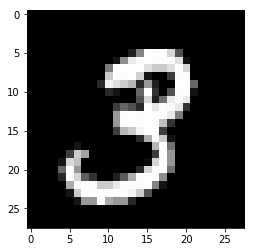

In [14]:
plt.imshow( single_image, cmap = 'gist_gray' )

###### Steps

- Placeholders 
- Variables
- Create Graph Operations
- Loss Function
- Optimizer
- Create Session
- Evaluate

In [36]:
x      = tf.placeholder( tf.float32, shape = [ None, 784 ] )
y_true = tf.placeholder( tf.float32, shape = [ None, 10 ] )

W = tf.Variable( tf.zeros( [ 784, 10 ] ) )
b = tf.Variable( tf.zeros( [ 10 ] ) )

y = tf.matmul( x, W ) + b

cross_entropy = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2( labels = y_true, logits = y ) )

optimizer = tf.train.GradientDescentOptimizer( learning_rate = 0.375 )
train     = optimizer.minimize( cross_entropy )

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run( init )
    
    for step in range( 1000 ):
        batch_x, batch_y = mnist.train.next_batch( 100 )
        sess.run( train, feed_dict = { x : batch_x, y_true : batch_y } )
        
    correct_prediction = tf.equal( tf.argmax( y, axis = 1 ), tf.argmax( y_true, axis = 1 ) )
    accuracy           = tf.reduce_mean( tf.cast( correct_prediction, tf.float32 ) )
    
    print( sess.run( accuracy, feed_dict = { x : mnist.test.images, y_true : mnist.test.labels } ) )

0.9214


### Optimized MNIST

In [59]:
def init_weights( shape ):
    init_random_dist = tf.truncated_normal( shape, stddev = 0.1 )
    return tf.Variable( init_random_dist )

In [60]:
def init_bias( shape ):
    init_bias_vals = tf.constant( 0.1, shape = shape )
    return tf.Variable( init_bias_vals )

In [61]:
def conv2d( x, W ):
    # x = [ batch, w, h, channels ]
    # W = [ filter h, filter w, channels in, channels out ]
    return tf.nn.conv2d( x, W, strides = [ 1, 1, 1, 1 ], padding = 'SAME' )

In [62]:
def max_pool_2by2( x ):
    # x = [ batch, h, w, channels ]
    return tf.nn.max_pool( x, ksize = [ 1, 2, 2, 1 ], strides = [ 1, 2, 2, 1 ], padding = 'SAME' )

In [63]:
def convolutional_layer( input_x, shape ):
    W = init_weights( shape )
    b = init_bias( [ shape[ 3 ] ] )
    
    return tf.nn.relu( conv2d( input_x, W ) + b )

In [64]:
def normal_full_layer( input_layer, size ):
    input_size = int( input_layer.get_shape()[1] )
    W          = init_weights( [ input_size, size ] )
    b          = init_bias( [ size ] )
    
    return tf.matmul( input_layer, W ) + b

In [65]:
mnist = input_data.read_data_sets( os.path.join( "C:", "Users", "andre", "Desktop", "GitHub", "Data", "MNIST_data" ), one_hot = True )

Extracting C:Users\andre\Desktop\GitHub\Data\MNIST_data\train-images-idx3-ubyte.gz
Extracting C:Users\andre\Desktop\GitHub\Data\MNIST_data\train-labels-idx1-ubyte.gz
Extracting C:Users\andre\Desktop\GitHub\Data\MNIST_data\t10k-images-idx3-ubyte.gz
Extracting C:Users\andre\Desktop\GitHub\Data\MNIST_data\t10k-labels-idx1-ubyte.gz


In [67]:
x      = tf.placeholder( tf.float32, shape = [ None, 784 ] )
y_true = tf.placeholder( tf.float32, shape = [ None, 10 ] )

# -1 is essentially the None dimension
x_image = tf.reshape( x, [ -1, 28, 28, 1 ] )

# Compute 32 features for each 5x5 window
convo_1      = convolutional_layer( x_image, shape = [ 5, 5, 1, 32 ] )
convo_1_pool = max_pool_2by2( convo_1 )

convo_2      = convolutional_layer( convo_1_pool, shape = [ 5, 5, 32, 64 ] )
convo_2_pool = max_pool_2by2( convo_2 )

convo_2_flat   = tf.reshape( convo_2_pool, [ -1, 7 * 7 * 64 ] )
full_layer_one = tf.nn.relu( normal_full_layer( convo_2_flat, 1024 ) )

hold_prob        = tf.placeholder( tf.float32 )
full_one_dropout = tf.nn.dropout( full_layer_one, keep_prob = hold_prob )

y_pred = normal_full_layer( full_one_dropout, 10 )

cross_entropy = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2( labels = y_true, logits = y_pred ) )

optimizer = tf.train.AdamOptimizer( learning_rate = 0.001 )
train     = optimizer.minimize( cross_entropy )

init  = tf.global_variables_initializer()
steps = 500

with tf.Session() as sess:
    sess.run( init )
    
    for step in range( steps ):
        batch_x, batch_y = mnist.train.next_batch( 50 )
        sess.run( train, feed_dict = { x         : batch_x, 
                                       y_true    : batch_y, 
                                       hold_prob : 0.5 } )
        
        if step % 100 == 0:
            print( "ON STEP: {}".format( step ) )
            print( "ACCURACY: " )
        
            correct_prediction = tf.equal( tf.argmax( y_pred, axis = 1 ), tf.argmax( y_true, axis = 1 ) )
            accuracy           = tf.reduce_mean( tf.cast( correct_prediction, tf.float32 ) )
    
            print( sess.run( accuracy, feed_dict = { x         : mnist.test.images, 
                                                     y_true    : mnist.test.labels, 
                                                     hold_prob : 1.0 } ) )
            print( "\n" )

ON STEP: 0
ACCURACY: 
0.1696


ON STEP: 100
ACCURACY: 
0.9373


ON STEP: 200
ACCURACY: 
0.9638


ON STEP: 300
ACCURACY: 
0.9671


ON STEP: 400
ACCURACY: 
0.9756


